<a href="https://colab.research.google.com/github/HegdeSiddesh/cs6910_assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
np.random.seed(137) # To ensure that the random number generated are the same for every iteration
import warnings
#warnings.filterwarnings("ignore")
!pip install wandb -qq
import wandb
#from wandb.keras import WandbCallback

     |████████████████████████████████| 1.7 MB 15.1 MB/s 
     |████████████████████████████████| 181 kB 64.1 MB/s 
     |████████████████████████████████| 144 kB 68.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


In [ ]:
wandb.login()

wandb: Currently logged in as: hegdesiddesh (use `wandb login --relogin` to force relogin)


True

In [ ]:
wandb.init(project="Assignment_1", name="Question_1")

##Question 1

Download the fashion-MNIST dataset and plot 1 sample image for each class.

In [2]:
#Load the fashion MNIST data 
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

#Normalize the data
x_train_full = x_train_full/255.0
x_test = x_test/255.0

#Splitting to get 10% data as validation set
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.1, random_state=137)

y_train_unencoded = y_train
#One hot encoding of the class labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.expand_dims(y_train,1)).toarray()
y_val = encoder.fit_transform(np.expand_dims(y_val,1)).toarray()
y_test = encoder.fit_transform(np.expand_dims(y_test,1)).toarray()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
#Get indices for the unique class labels
unique_indices = np.unique(y_train_unencoded, return_index=True)

# Label reference : https://github.com/zalandoresearch/fashion-mnist
image_label = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

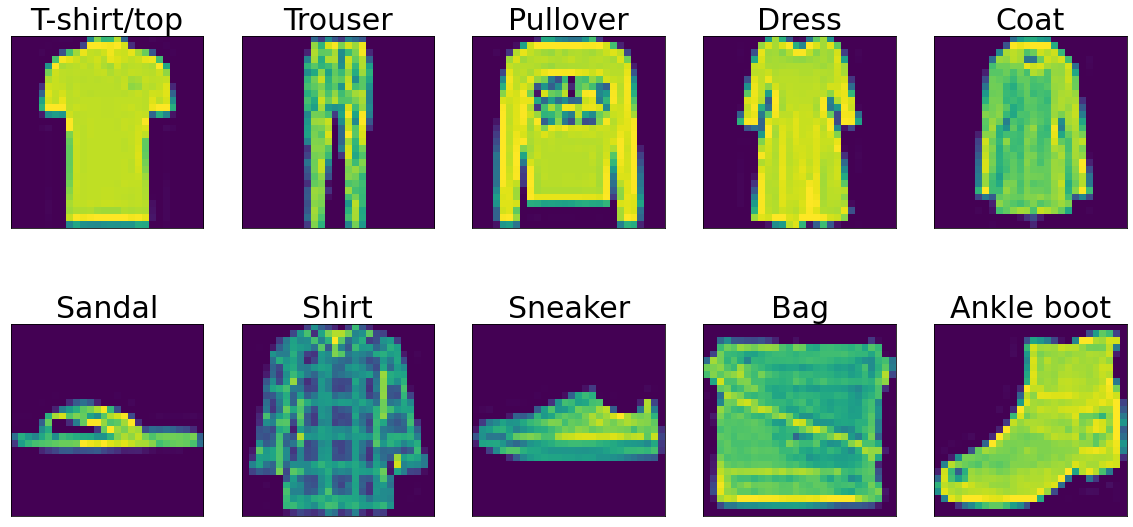

In [ ]:
image_num=0
f, axarr = plt.subplots(2,5, sharex='col', sharey='row', figsize=(20,20))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)

# Plotting 2*5 subplot of images of different labels
for i in range(0,2):
  for j in range(0,5):
    axarr[i,j].imshow(x_train[unique_indices[1][image_num]])
    axarr[i,j].set_title(image_label[image_num], fontdict = {'fontsize' : 30})
    axarr[i,j].set_xticks([])
    axarr[i,j].set_yticks([])
    caption = image_label[image_num]
    wandb.log({"examples": [wandb.Image(x_train[unique_indices[1][image_num]], caption=caption)]})
    image_num += 1

plt.show()

In [ ]:
wandb.finish()

##Question 2

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.



Your code should be flexible so that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.





In [ ]:
class FeedForwardNeuralNetwork():
  def __init__(self, hidden_layer_sizes, epochs, learning_rate):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.learning_rate = learning_rate
    self.input_layer_size=0
    self.output_layer_size=1
    self.epochs = epochs
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}
    self.dw = {}
    self.db = {}
    self.dA = {}
    self.dH = {}
    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []

  def initialize_weights(self):
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    np.random.seed(137)
    for i in range(weight_counts):
      # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
      self.weights[i+1] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])
      # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
      # Creates a row of biases corresponding to each weight of the layer
      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))



  def softmax(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def sigmoid(self,X):
    #Utility to compute sigmoid function
    return 1.0/(1.0+np.exp(-X))

  def sigmoid_gradient(self,X):
    #Utility to compute sigmoid function
    #sigmoid = self.sigmoid(X)
    return X*(1-X)

  def cross_entropy(self,Y_true,Y_pred):
    #Utility to compute cross entropy loss
    # loss= -np.sum(np.sum(Y_true*np.log(Y_pred)))
    # return loss
    yl=np.multiply(Y_pred,Y_true)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl

  def cross_entropy_gradient(self,Y_true,Y_pred):
    #Utility to compute gradient of cross entropy loss
    return -Y_true/(Y_pred)

  def tanh(self,X):
    # Utility to compute tanh function
    return np.tanh(X)

  def tanh_derivate(self,X):
    # Utility to compute tanh derivative
    return 1 - (np.tanh(X) ** 2)

  def relu(self,X):
    # Utility to compute relu function
    return X * (X > 0)

  def relu_derivative(self,X):
    # Utility to compute relu derivative
    X[X <= 0.0] = 0.0
    X[X > 0.0] = 1.0
    return X


  def forward_propogation(self, X):

    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)
    #print((self.H[0]).dtype)
    self.H[0] = self.H[0].astype('float128')


    #Compute a(x) = W_x*h(x-1) + b and h(a(x)) = sigmoid(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    self.H[len(self.hidden_layer_sizes)+1] = self.softmax(self.A[len(self.hidden_layer_sizes)+1]) 
    return

  def backward_propogation(self, X, Y,  dw_i, db_i):

    #Compute the gradient of loss wrt the activation of output layer
    #self.dH[len(self.hidden_layer_sizes)+1] = self.cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])
    self.dA[len(self.hidden_layer_sizes)+1] = -(Y - self.H[len(self.hidden_layer_sizes)+1])#cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])

    #Compute the partial derivatives for the weights and biases of the layers
    for i in range(len(self.hidden_layer_sizes), -1, -1):
      #eg:(assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
      dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
      #eg:(assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
      db_i[i+1] = self.dA[i+1]
      #eg:(assuming 2 hidden layers) dL/dH2 = dA3/dH2 * dL/dA3 = d(W3*H2 + B3)/dH2 * dL/dA3 = W3 * dL/dA3
      self.dH[i] = np.matmul(self.dA[i+1],self.weights[i+1].T)
      #eg:(assuming 2 hidden layers) dL/dA2 = dH2/dA2 * dL/dH2 = d(sigmoid(A2))/dA2 * dL/dH2 = sigmoid(A2) * (1-sigmoid(A2)) * dL/dH2 (for sigmoid activation)
      ## THIS IS HADAMARD PRODUCT IE NOT DOT PRODUCT
      self.dA[i] = np.multiply(self.sigmoid_gradient(self.H[i]), self.dH[i])    
    return


  def gradient_descent(self):
    for i in range(len(self.hidden_layer_sizes)+1):
        # w_t = w_{t-1} - eta*(dL/dw)
        self.weights[i+1] = self.weights[i+1] - self.learning_rate * self.dw[i+1]
        # b_t = b_{t-1} - eta*(dL/db)
        self.biases[i+1] = self.biases[i+1] - self.learning_rate * self.db[i+1]
    return 



  def fit(self, X, Y):
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    for e in range(self.epochs):
      #Gradients computed for this iteration/epoch
      y_preds = []

      for i in range(len(self.hidden_layer_sizes)+1):
        self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
        self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))

      for x, y in zip(X, Y):
        dw_i = {}
        db_i = {}

        #Forward Propogation
        self.forward_propogation(x)

        #loss and prediction class
        y_preds.append(self.H[len(self.hidden_layer_sizes)+1])
        
        #Backward Propogation using Loss funtion MSE
        self.backward_propogation(x,y, dw_i, db_i) 

        for i in range(len(self.hidden_layer_sizes)+1):
          self.dw[i+1] += dw_i[i+1]
          self.db[i+1] += db_i[i+1]

      #Update weights based on loss(GD hence once every epoch update)
      self.gradient_descent()
      y_preds = np.array(y_preds).squeeze()
      print("Epoch: ",e," Loss: ",self.cross_entropy(Y, y_preds) )


  def predict(self, X):
    #Find the predictions based on the fitted model
    values = self.forward_propogation(X)
    predictions = self.H[len(self.hidden_layer_sizes)+1]
    return predictions
      


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(np.expand_dims(y_train,1)).toarray()

model = FeedForwardNeuralNetwork([100,256, 512], 10, 0.0001)

model.fit(x_train[0:10000], y_encoded[0:10000])

Epoch:  0  Loss:  11.158632878711602577
Epoch:  1  Loss:  56.459906650211561987
Epoch:  2  Loss:  103.18513388453057602
Epoch:  3  Loss:  145.23074438298768855
Epoch:  4  Loss:  178.47091976878302264
Epoch:  5  Loss:  203.24233294268224395
Epoch:  6  Loss:  190.9932346744848967
Epoch:  7  Loss:  194.9111013237063116
Epoch:  8  Loss:  202.96914933221613472
Epoch:  9  Loss:  242.3250418288858484


In [ ]:
#Check predictions for first 10 datapoints
for i in range(10):
  print(model.predict(x_train[i]))
  print(y_encoded[i])


[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Issue might be in sending dw_i to the functions (check call by value or call by reference)

##Question 3

In [ ]:
##Create classes for loss functions
#cross entropy loss

#Create classes for optimizers
#1.SGD
#2.NAG
#3.Momentum
#4.rmsprop
#7.adam
#6.nadam


In [3]:
def accuracy(y_true, y_pred):
  acc = np.sum(np.equal(y_true,y_pred))/y_true.shape[0]
  return acc

In [4]:
class FeedForwardNeuralNetwork():
  def __init__(self, hidden_layer_sizes, optimizer, loss_function, activation_function, output_activation, epochs = 1000, batch_size = 1024, initialization = "Random", log=0):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.activation_function = activation_function
    self.output_activation = output_activation
    self.input_layer_size=0
    self.output_layer_size=1
    self.epochs = epochs
    self.batch_size = batch_size
    self.initialization = initialization
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}
    self.dw = {}
    self.db = {}
    self.dA = {}
    self.dH = {}
    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []
    self.log = log


  def initialize_weights(self):
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    np.random.seed(137)
    self.optimizer.initialize(self.layer_sizes)
    for i in range(weight_counts):

      if self.initialization == "Random":
        # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
        self.weights[i+1] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])
        # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
        # Creates a row of biases corresponding to each weight of the layer

      if self.initialization == "Xavier-Normal":
        limit = np.sqrt(2 / float(self.layer_sizes[i] + self.layer_sizes[i+1]))
        self.weights[i+1] = np.random.normal(0.0, limit, size=(self.layer_sizes[i], self.layer_sizes[i+1]))

      if self.initialization == "Xavier-Uniform":
        limit = np.sqrt(6 / float(self.layer_sizes[i] + self.layer_sizes[i+1]))
        self.weights[i+1] = np.random.uniform(low=-limit, high=limit, size=(self.layer_sizes[i], self.layer_sizes[i+1]))

      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))


  def forward_propogation(self, X):

    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)
    #print((self.H[0]).dtype)
    #self.H[0] = self.H[0].astype('float128')

    #Compute a(x) = W_x*h(x-1) and h(a(x)) = sigmoid(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      #print("A :",np.isfinite(self.A[i+1]).all())
      self.H[i+1] = self.activation_function.compute_activation(self.A[i+1])
      #print("H :",np.isfinite(self.H[i+1]).all())

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    #print("A :",np.isfinite(self.A[len(self.hidden_layer_sizes)+1]).all())
    self.H[len(self.hidden_layer_sizes)+1] = self.output_activation.compute_activation(self.A[len(self.hidden_layer_sizes)+1]) 
    #print("H :",np.isfinite(self.H[len(self.hidden_layer_sizes)+1]).all())
    return

  def backward_propogation(self, X, Y,  dw_i, db_i):

    #Compute the gradient of loss wrt the activation of output layer
    #self.dH[len(self.hidden_layer_sizes)+1] = self.cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])
    self.dA[len(self.hidden_layer_sizes)+1] = -(Y - self.H[len(self.hidden_layer_sizes)+1])#cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])

    #Compute the partial derivatives for the weights and biases of the layers
    for i in range(len(self.hidden_layer_sizes), -1, -1):
      #eg:(assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
      dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
      #eg:(assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
      db_i[i+1] = self.dA[i+1]
      #eg:(assuming 2 hidden layers) dL/dH2 = dA3/dH2 * dL/dA3 = d(W3*H2 + B3)/dH2 * dL/dA3 = W3 * dL/dA3
      self.dH[i] = np.matmul(self.dA[i+1],self.weights[i+1].T)
      #eg:(assuming 2 hidden layers) dL/dA2 = dH2/dA2 * dL/dH2 = d(sigmoid(A2))/dA2 * dL/dH2 = sigmoid(A2) * (1-sigmoid(A2)) * dL/dH2 (for sigmoid activation)
      ## THIS IS HADAMARD PRODUCT IE NOT DOT PRODUCT
      self.dA[i] = np.multiply(self.activation_function.compute_derivative(self.H[i]), self.dH[i])    
    return dw_i, db_i


  def fit(self, X, Y, X_val, Y_val):
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    #if self.optimizer.optimizer_name()=="nag":
    #  self.optimizer.set_model(self, X, Y)
    for e in range(self.epochs):
      #Gradients computed for this iteration/epoch
      y_preds = []

      count = -1
      for i in range(len(self.hidden_layer_sizes)+1):
        self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
        self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))

      for x, y in zip(X, Y):
        dw_i = {}
        db_i = {}
        count += 1

        if count==self.batch_size:
          #print("Done wih batch")
          count = 0
          if self.optimizer.optimizer_name()=="nag":
            w_lookahead = {}
            b_lookahead = {}
            for i in range(len(self.hidden_layer_sizes)+1):
              w_lookahead[i+1] = self.weights[i+1] - self.optimizer.gamma*self.optimizer.update_history_w[i+1]
              b_lookahead[i+1] = self.biases[i+1] - self.optimizer.gamma*self.optimizer.update_history_b[i+1]
            
            weights_old = self.weights
            biases_old = self.biases
            self.weights = w_lookahead
            self.biases = b_lookahead
            self.forward_propogation(x)
            dw_lookahead, db_lookahead = self.backward_propogation(x,y, dw_i, db_i) 
            self.weights, self.biases = self.optimizer.update_parameters(weights_old, biases_old, dw_lookahead, db_lookahead, self.hidden_layer_sizes)

          else: 
            self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, self.hidden_layer_sizes)
          for i in range(len(self.hidden_layer_sizes)+1):
            self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
            self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))


        #Forward Propogation
        self.forward_propogation(x)

        #loss and prediction class
        y_preds.append(self.H[len(self.hidden_layer_sizes)+1])
        
        #Backward Propogation using Loss funtion
        self.backward_propogation(x,y, dw_i, db_i) 

        for i in range(len(self.hidden_layer_sizes)+1):
          self.dw[i+1] += dw_i[i+1]
          self.db[i+1] += db_i[i+1]

      #Update weights based on loss(GD hence once every epoch update)
      if self.optimizer.optimizer_name()=="nag":
        w_lookahead = {}
        b_lookahead = {}
        for i in range(len(self.hidden_layer_sizes)+1):
          w_lookahead[i+1] = self.weights[i+1] - self.optimizer.gamma*self.optimizer.update_history_w[i+1]
          b_lookahead[i+1] = self.biases[i+1] - self.optimizer.gamma*self.optimizer.update_history_b[i+1]
        
        weights_old = self.weights
        biases_old = self.biases
        self.weights = w_lookahead
        self.biases = b_lookahead
        self.forward_propogation(x)
        dw_lookahead, db_lookahead = self.backward_propogation(x,y, dw_i, db_i) 
        self.weights, self.biases = self.optimizer.update_parameters(weights_old, biases_old, dw_lookahead, db_lookahead, self.hidden_layer_sizes)

      else:  
        self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, self.hidden_layer_sizes)
      #self.gradient_descent()
      y_preds = np.array(y_preds).squeeze()
      y_preds_validation = self.predict(X_val)
      training_loss = self.loss_function.compute_loss(Y, y_preds)
      validation_loss = self.loss_function.compute_loss(Y_val, y_preds_validation)
      training_accuracy = accuracy(np.argmax(Y,1), np.argmax(y_preds,1))
      validation_accuracy = accuracy(np.argmax(Y_val,1), np.argmax(y_preds_validation,1))
      if self.log==1:
        #Log metrics to wandb
        wandb.log({"Training_accuracy": training_accuracy, "Validation_accuracy": validation_accuracy, "Training_loss": training_loss, "Validation_loss": validation_loss, 'Epoch': e+1})

      print("Epoch: ",e+1," Training Loss: ",training_loss, " Validation Loss:",validation_loss ," Training Accuracy: ",training_accuracy, " Validation Accuracy:", validation_accuracy)
    
    return training_loss, validation_loss, training_accuracy, validation_accuracy

  def predict(self, X):
    #Find the predictions based on the fitted model
    y_pred = []
    for x in X:
      values = self.forward_propogation(x)
      predictions = self.H[len(self.hidden_layer_sizes)+1]
      y_pred.append(predictions)

    y_pred = np.array(y_pred).squeeze()
    return y_pred
      


In [5]:
class GD():
  def __init__(self, learning_rate = 0.001):
    self.learning_rate = learning_rate

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
  
  def initialize(self, all_layers):
    return

  def optimizer_name(self):
    return "gd"

  def update_parameters(self, weights, biases, dw, db, layers):
    for i in range(len(layers)+1):
        # w_t = w_{t-1} - eta*(dL/dw)
        weights[i+1] = weights[i+1] - self.learning_rate * dw[i+1]
        # b_t = b_{t-1} - eta*(dL/db)
        biases[i+1] = biases[i+1] - self.learning_rate * db[i+1]
    return weights, biases


class MomentumGD():
  def __init__(self, learning_rate = 0.001, gamma = 0.001):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.initialized = False
    self.update_history_w = {}
    self.update_history_b = {}
  
  def optimizer_name(self):
    return "momentum"
  
  def initialize(self, all_layers):
    self.update_history_w.clear()
    self.update_history_b.clear()
    for i in range(len(all_layers)-1):
      self.update_history_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.update_history_b[i+1] = np.zeros((1, all_layers[i+1]))
  
  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.update_history_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.update_history_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):

    for i in range(len(layers)+1):
        self.update_history_w[i+1] =self.gamma*self.update_history_w[i+1] + self.learning_rate*dw[i+1]
        weights[i+1] = weights[i+1] - self.update_history_w[i+1]

        self.update_history_b[i+1] =self.gamma*self.update_history_b[i+1] + self.learning_rate*db[i+1]
        biases[i+1] = biases[i+1] - self.update_history_b[i+1]
        
    return weights, biases


class NAG():
  def __init__(self, learning_rate = 0.001, gamma = 0.9):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.initialized = False
    self.update_history_w = {}
    self.update_history_b = {}
    self.w_look_ahead={}
    self.b_look_ahead={}
    self.dw_look_ahead={}
    self.db_look_ahead={}
    #self.model = None
    #self.X = None
    #self.Y = None

  #def set_model(self, model, X, Y):
  #  self.model = model
  #  self.X = X
  #  self.Y = Y
  
  def optimizer_name(self):
    return "nag"
  
  def initialize(self, all_layers):
    self.update_history_w.clear()
    self.update_history_b.clear()
    self.dw_look_ahead.clear()
    self.db_look_ahead.clear()
    self.w_look_ahead.clear()
    self.b_look_ahead.clear()

    for i in range(len(all_layers)-1):
      self.update_history_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.update_history_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.dw_look_ahead[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.db_look_ahead[i+1] = np.zeros((1, all_layers[i+1]))
      self.w_look_ahead[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.b_look_ahead[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.update_history_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.update_history_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):
    
    #for i in range(len(layers)+1):
    #    self.w_look_ahead[i+1] = weights[i+1] - self.gamma*self.update_history_w[i+1]
    #    self.b_look_ahead[i+1] = biases[i+1] - self.gamma*self.update_history_b[i+1]

    #Compute backpropogation to obtain the gradients for lookahead parameters
    #self.dw_look_ahead, self.db_look_ahead = self.model.backward_propogation(self.X, self.Y, self.w_look_ahead, self.b_look_ahead)

    for i in range(len(layers)+1):

        self.update_history_w[i+1] = self.gamma*self.update_history_w[i+1] + self.learning_rate*dw[i+1]
        self.update_history_b[i+1] = self.gamma*self.update_history_b[i+1] + self.learning_rate*db[i+1]

        weights[i+1] = weights[i+1] - self.update_history_w[i+1]
        biases[i+1] = biases[i+1] - self.update_history_b[i+1]
        
    return weights, biases


class RMSProp():
  def __init__(self, learning_rate = 0.001, gamma = 0.001, epsilon = 1e-8, v_w = 0.001, v_b = 0.001):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.epsilon = epsilon
    self.v_w = {}
    self.v_b = {}
    self.initialized = False

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
  
  def optimizer_name(self):
    return "rmsprop"
  
  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    self.epsilon = parameters["epsilon"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    # self.v_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    # self.v_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):
    #if self.initialized == False:
      #self.initialized = True
      #print(weights[1].shape[0])
      #print(weights[len(weights)].shape[-1])
      #all_layers = [weights[1].shape[0]] + layers + [weights[len(weights)].shape[-1]]
      #for i in range(len(layers)+1):
      #  self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      #  self.v_b[i+1] = np.zeros((1, all_layers[i+1]))

    for i in range(len(layers)+1):
        self.v_w[i+1] =self.gamma*self.v_w[i+1] + (1-self.gamma)* ((dw[i+1])**2)
        self.v_b[i+1] =self.gamma*self.v_b[i+1] + (1-self.gamma)* ((db[i+1])**2)

        weights[i+1] = weights[i+1] - ((self.learning_rate)/np.sqrt(self.v_w[i+1] + self.epsilon))*dw[i+1]
        biases[i+1] = biases[i+1] - ((self.learning_rate)/np.sqrt(self.v_b[i+1] + self.epsilon))*db[i+1]
        
    return weights, biases


class Adam():
  def __init__(self, learning_rate = 0.001, gamma = 0.001, epsilon = 1e-8):
    self.learning_rate = learning_rate
    self.beta1 = 0.9
    self.beta2 = 0.999
    self.epsilon = epsilon
    self.initialized = False
    self.v_w = {}
    self.v_b = {}
    self.m_w = {}
    self.m_b = {}
    self.iterations = 1;

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    self.m_w.clear()
    self.m_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.m_b[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate
  
  def optimizer_name(self):
    return "adam"

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.beta1 = parameters["beta1"]
    self.beta2 = parameters["beta2"]
    self.epsilon = parameters["epsilon"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.v_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.v_b[i+1] = np.zeros((1, layer_sizes[i+1]))
    #  self.m_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.m_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):

    #if self.initialized == False:
    #  self.initialized = True
    #  all_layers = [weights[1].shape[0]] + layers + [weights[len(weights)].shape[-1]]
    #  for i in range(len(layers)+1):
    #    self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
    #    self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.m_b[i+1] = np.zeros((1, all_layers[i+1]))


    for i in range(len(layers)+1):

        self.m_w[i+1] = self.beta1*self.m_w[i+1] + (1-self.beta1)* (dw[i+1])
        self.m_b[i+1] = self.beta1*self.m_b[i+1] + (1-self.beta1)* (db[i+1])

        self.v_w[i+1] = self.beta2*self.v_w[i+1] + (1-self.beta2)* ((dw[i+1])**2)
        self.v_b[i+1] = self.beta2*self.v_b[i+1] + (1-self.beta2)* ((db[i+1])**2)

        m_w_hat = self.m_w[i+1]/(1-(self.beta1**self.iterations))
        m_b_hat = self.m_b[i+1]/(1-(self.beta1**self.iterations))
			  
        v_w_hat = self.v_w[i+1]/(1-(self.beta2**self.iterations))
        v_b_hat = self.v_b[i+1]/(1-(self.beta2**self.iterations))

        weights[i+1] = weights[i+1] - ((self.learning_rate)/(np.sqrt(v_w_hat) + self.epsilon))*(m_w_hat)
        biases[i+1] = biases[i+1] - ((self.learning_rate)/(np.sqrt(v_b_hat) + self.epsilon))*(m_b_hat)

    self.iterations += 1
        
    return weights, biases


class Nadam():
  #Reference : http://cs229.stanford.edu/proj2015/054_report.pdf
  #Formula reference: https://towardsdatascience.com/10-gradient-descent-optimisation-algorithms-86989510b5e9
  def __init__(self, learning_rate = 0.001, gamma = 0.001, epsilon = 1e-8):
    self.learning_rate = learning_rate
    self.beta1 = 0.9
    self.beta2 = 0.999
    self.epsilon = epsilon
    self.initialized = False
    self.v_w = {}
    self.v_b = {}
    self.m_w = {}
    self.m_b = {}
    self.iterations = 1;

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    self.m_w.clear()
    self.m_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.m_b[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate
  
  def optimizer_name(self):
    return "nadam"

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.beta1 = parameters["beta1"]
    self.beta2 = parameters["beta2"]
    self.epsilon = parameters["epsilon"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.v_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.v_b[i+1] = np.zeros((1, layer_sizes[i+1]))
    #  self.m_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.m_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):

    #if self.initialized == False:
    #  self.initialized = True
    #  all_layers = [weights[1].shape[0]] + layers + [weights[len(weights)].shape[-1]]
    #  for i in range(len(layers)+1):
    #    self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
    #    self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.m_b[i+1] = np.zeros((1, all_layers[i+1]))


    for i in range(len(layers)+1):

        self.m_w[i+1] = self.beta1*self.m_w[i+1] + (1-self.beta1)* (dw[i+1])
        self.m_b[i+1] = self.beta1*self.m_b[i+1] + (1-self.beta1)* (db[i+1])

        self.v_w[i+1] = self.beta2*self.v_w[i+1] + (1-self.beta2)* ((dw[i+1])**2)
        self.v_b[i+1] = self.beta2*self.v_b[i+1] + (1-self.beta2)* ((db[i+1])**2)

        m_w_hat = self.m_w[i+1]/(1-(self.beta1**self.iterations))
        m_b_hat = self.m_b[i+1]/(1-(self.beta1**self.iterations))
			  
        v_w_hat = self.v_w[i+1]/(1-(self.beta2**self.iterations))
        v_b_hat = self.v_b[i+1]/(1-(self.beta2**self.iterations))

        weights[i+1] = weights[i+1] - ((self.learning_rate)/(np.sqrt(v_w_hat) + self.epsilon))*(self.beta1 * m_w_hat + ((1-self.beta1)/(1-(self.beta1**self.iterations))*dw[i+1]))
        biases[i+1] = biases[i+1] - ((self.learning_rate)/(np.sqrt(v_b_hat) + self.epsilon))*(self.beta1 * m_b_hat + ((1-self.beta1)/(1-(self.beta1**self.iterations))*db[i+1]))

    self.iterations += 1
        
    return weights, biases


In [6]:
class Sigmoid():
  def compute_activation(self, X):
    return 1.0/(1.0+np.exp(-X))

  def compute_derivative(self, X):
    #Here X is the activation value
    #sigmoid = compute_activation(X)
    return X*(1-X)

class Softmax():
  def compute_activation(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def compute_derivative(self, X):
    #Here X is the activation value
    #softmax = self.compute_activation(X)
    return X*(1-X)

class Tanh():
  def compute_activation(self,X):
    return np.tanh(X)

  def compute_derivative(self,X):
    return 1 - (X ** 2)

class ReLU():
  def compute_activation(self,X):
    return X * (X > 0)

  def compute_derivative(self,X):
    X[X <= 0.0] = 0.0
    X[X > 0.0] = 1.0
    return X

In [7]:
class CrossEntropy():
  def compute_loss(self, Y_true, Y_pred):
    loss=np.multiply(Y_pred,Y_true)
    loss=loss[loss!=0]
    loss=-np.log(loss)
    loss=np.mean(loss)
    return loss

  def compute_derivative(self, Y_pred,Y_true):
    return -Y_true/(Y_pred)

In [ ]:
#Add layer sizes for the hidden layers
layers = [32, 64, 128, 256]


#all_layers = [x_train.shape[1]*x_train.shape[1]] + layers + [y_encoded.shape[1]]


optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
loss_functions = {"cross_entropy":CrossEntropy()}
activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "ReLU":ReLU()}


#Select optimizer(sgd)
optimizer_sgd = optimizers["gradient_descent"]
optimizer_parameters_sgd = {"learning_rate":0.0001}
optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)

#Select optimizer(momentum)
optimizer_momentum = optimizers["momentum_gd"]
optimizer_parameters_momentum = {"learning_rate":0.0001, "gamma":0.6}
#optimizer_parameters_momentum = {"learning_rate":0.01, "gamma":0.9}

optimizer_momentum.set_initial_parameters(optimizer_parameters_momentum)

#Select optimizer(nag)
optimizer_nag = optimizers["nag"]
optimizer_parameters_nag = {"learning_rate":0.001, "gamma":0.9}
optimizer_nag.set_initial_parameters(optimizer_parameters_nag)

#Select optimizer(rmsprop)
optimizer_rmsprop = optimizers["rmsprop"]
optimizer_parameters_rmsprop = {"learning_rate":0.01, "gamma":0.9, "epsilon":1e-8}
optimizer_rmsprop.set_initial_parameters(optimizer_parameters_rmsprop)

#Select optimizer(adam)
optimizer_adam = optimizers["adam"]
optimizer_parameters_adam = {"learning_rate":0.0001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8}
optimizer_adam.set_initial_parameters(optimizer_parameters_adam)

#Select optimizer(nadam)
optimizer_nadam = optimizers["nadam"]
optimizer_parameters_nadam = {"learning_rate":0.0001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8}
optimizer_nadam.set_initial_parameters(optimizer_parameters_nadam)


#Select loss function
loss_cross_entropy = loss_functions["cross_entropy"]


#Select activation(hidden layers)
activation_sigmoid = activation_functions["sigmoid"]
activation_softmax = activation_functions["softmax"]
activation_tanh = activation_functions["tanh"]
activation_relu = activation_functions["ReLU"]

#Select activation(output layer)
output_activation_softmax = activation_functions["softmax"]

#x_train = x_train.astype('float128')
model = FeedForwardNeuralNetwork(layers, optimizer_sgd, loss_cross_entropy, activation_sigmoid, output_activation_softmax, 5, 512, initialization = "Xavier-Normal")
model.fit(x_train, y_train, x_val, y_val)


In [ ]:
#Accuracy for test data
y_preds = model.predict(x_test)
print(accuracy(np.argmax(y_test,1), np.argmax(y_preds,1)))

0.7534



Ref : https://pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/

For Sigmoid/Tanh --> Use Xavier

Xavier Normal: For the normal distribution the limit value is constructed by averaging the Fin and Fout together and then taking the square-root (Jones, 2016). A zero-center (µ = 0) is then used:

Xavier Uniform: 

For Relu ---> Use He

##DEFAULT PARAMETERS:

GD : Learning_rate : 0.01

Momentum : Learning_rate : 0.001, gamma=0.9  (tune gamma with increments of 0.3)

NAG: Learning_rate : 0.001, gamma=0.9


In [ ]:
sweep_config = {
    #GridSearch over the hyperparameters
    'method': 'grid',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'gamma': {
            'values': [0.3, 0.6, 0.9]
        },
        'optimizer': {
            'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']
        },
        'activation': {
            'values': ['sigmoid' , 'tanh', 'relu']
        },
        #'output_activation': {
        #    'values': ['softmax']
        #},
        'hidden_layers': {
            'values': [ [32,64],[32,64,128],[32,64,128,256]]
        },
        'batch_size':{
            'values':[16,32,64]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Assignment_1")

Create sweep with ID: buk8e4xo
Sweep URL: https://wandb.ai/hegdesiddesh/Assignment_1/sweeps/buk8e4xo


In [ ]:
def train():

    config_defaults = {
        'epochs': 2,
        'learning_rate': 0.0001,
        'hidden_layers':[50,75],
        'optimizer':'nadam',
        'activation':'sigmoid',
        'gamma' : 0.6,
        #'output_activation': 'softmax',
        'batch_size':100
    }

    '''
    # Initialize a new wandb run
    wandb.init(project='Assignment_1',config=config_defaults, name="Question_345")
    config = wandb.init().config
    '''
    
    with wandb.init(project='Assignment_1',config = sweep_config, name="Question_345"):
      config = wandb.init().config

      #Setting custom run name 
      wandb.run.name = 'epochs_' + str(config.epochs) + '_activation_' + config.activation + '_optimizer_' + config.optimizer + '_layers' + str(len(config.hidden_layers)) + 'gamma_' + str(config.gamma) + '_learning_rate_' + str(config.learning_rate) + '_batch_size_' + str(config.batch_size)
      
      # Config is a variable that holds and saves hyperparameters and inputs
      learning_rate = config.learning_rate
      gamma = config.gamma
      epochs = config.epochs
      hidden_layers = config.hidden_layers

      if config.activation=="sigmoid":
        activation = activation_sigmoid
      
      if config.activation=="tanh":
        activation = activation_tanh

      if config.activation=="relu":
        activation = activation_relu
      #activation = config.activation

      #if config.output_activation=="softmax":
      #  output_activation = output_activation_softmax
      #output_activation = config.output_activation
      output_activation = output_activation_softmax

      if config.optimizer=="sgd":
        #Select optimizer(sgd)
        optimizer_sgd = optimizers["gradient_descent"]
        optimizer_parameters_sgd = {"learning_rate":config.learning_rate}
        optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)
        optimizer = optimizer_sgd
      if config.optimizer=="momentum":
        #Select optimizer(momentum)
        optimizer_momentum = optimizers["momentum_gd"]
        optimizer_parameters_momentum = {"learning_rate":config.learning_rate, "gamma":config.gamma}
        optimizer_momentum.set_initial_parameters(optimizer_parameters_momentum)
        optimizer = optimizer_momentum
      if config.optimizer=="nag":
        #Select optimizer(momentum)
        optimizer_nag = optimizers["nag"]
        optimizer_parameters_nag = {"learning_rate":config.learning_rate, "gamma":config.gamma}
        optimizer_nag.set_initial_parameters(optimizer_parameters_nag)
        optimizer = optimizer_nag
      if config.optimizer=="rmsprop":
        #Select optimizer(rmsprop)
        optimizer_rmsprop = optimizers["rmsprop"]
        optimizer_parameters_rmsprop = {"learning_rate":config.learning_rate, "gamma":config.gamma, "epsilon":1e-8}
        optimizer_rmsprop.set_initial_parameters(optimizer_parameters_rmsprop)
        optimizer = optimizer_rmsprop
      if config.optimizer=="adam":
        #Select optimizer(adam)
        optimizer_adam = optimizers["adam"]
        optimizer_parameters_adam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8}
        optimizer_adam.set_initial_parameters(optimizer_parameters_adam)
        optimizer = optimizer_adam
      if config.optimizer=="nadam":
        #Select optimizer(nadam)
        optimizer_nadam = optimizers["nadam"]
        optimizer_parameters_nadam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8}
        optimizer_nadam.set_initial_parameters(optimizer_parameters_nadam)
        optimizer = optimizer_nadam
      #optimizer = config.optimizer
      batch_size = config.batch_size

      #Model training 
      #Ensure that log=1 parameter is set for logging onto wandb
      model = FeedForwardNeuralNetwork(hidden_layers, optimizer, loss_cross_entropy, activation, output_activation, epochs, batch_size, initialization = "Xavier-Normal", log=1)
      train_loss, val_loss, train_accuracy, val_accuracy = model.fit(x_train, y_train, x_val, y_val)

      #Log validation accuracy for this run
      wandb.log({"accuracy": val_accuracy})



In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: ifsgtqy9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  0.7468258552911228  Validation Loss: 0.6060949188772989  Training Accuracy:  0.7201296296296297  Validation Accuracy: 0.7723333333333333
Epoch:  2  Training Loss:  0.4654304890376378  Validation Loss: 0.595755102413299  Training Accuracy:  0.8300555555555555  Validation Accuracy: 0.7825
Epoch:  3  Training Loss:  0.4235380419708758  Validation Loss: 0.6080854031866472  Training Accuracy:  0.8433703703703703  Validation Accuracy: 0.7795
Epoch:  4  Training Loss:  0.39667456080378244  Validation Loss: 0.6207176991685434  Training Accuracy:  0.8522592592592593  Validation Accuracy: 0.7828333333333334
Epoch:  5  Training Loss:  0.37811131009663235  Validation Loss: 0.629909405097881  Training Accuracy:  0.8582222222222222  Validation Accuracy: 0.7836666666666666


wandb: Agent Starting Run: o88u79es with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  0.6926886022985076  Validation Loss: 0.5948352866603158  Training Accuracy:  0.7393518518518518  Validation Accuracy: 0.7796666666666666
Epoch:  2  Training Loss:  0.4577927581350515  Validation Loss: 0.6180339112621895  Training Accuracy:  0.8312777777777778  Validation Accuracy: 0.7723333333333333
Epoch:  3  Training Loss:  0.4158789862461232  Validation Loss: 0.6471916049432659  Training Accuracy:  0.8459444444444445  Validation Accuracy: 0.7621666666666667
Epoch:  4  Training Loss:  0.3917571950503252  Validation Loss: 0.6355761451542881  Training Accuracy:  0.8547592592592592  Validation Accuracy: 0.7696666666666667
Epoch:  5  Training Loss:  0.37677852026443603  Validation Loss: 0.628355825370835  Training Accuracy:  0.8587037037037037  Validation Accuracy: 0.7786666666666666


wandb: Agent Starting Run: pg2tkdap with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nagrmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: ERROR Run pg2tkdap errored: UnboundLocalError("local variable 'optimizer' referenced before assignment")
wandb: Agent Starting Run: qkm6r8uk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  0.7597277688978944  Validation Loss: 0.688578996733745  Training Accuracy:  0.7115185185185186  Validation Accuracy: 0.7496666666666667
Epoch:  2  Training Loss:  0.6383408285148662  Validation Loss: 0.683903539828666  Training Accuracy:  0.7700925925925926  Validation Accuracy: 0.7551666666666667
Epoch:  3  Training Loss:  0.595583709613848  Validation Loss: 0.7866725285510362  Training Accuracy:  0.7882777777777777  Validation Accuracy: 0.7345
Epoch:  4  Training Loss:  0.57551623071006  Validation Loss: 0.6892119960478058  Training Accuracy:  0.7922592592592592  Validation Accuracy: 0.7631666666666667
Epoch:  5  Training Loss:  0.5704452442367808  Validation Loss: 0.7150701855707853  Training Accuracy:  0.7980185185185186  Validation Accuracy: 0.7476666666666667


wandb: Agent Starting Run: 18owy83n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  0.7861589872471995  Validation Loss: 0.7774645455391661  Training Accuracy:  0.6982592592592592  Validation Accuracy: 0.7071666666666667
Epoch:  2  Training Loss:  0.650919378109623  Validation Loss: 0.7101618240867945  Training Accuracy:  0.7646481481481482  Validation Accuracy: 0.7525
Epoch:  3  Training Loss:  0.6029644427165245  Validation Loss: 0.6788206460725463  Training Accuracy:  0.7848888888888889  Validation Accuracy: 0.7545
Epoch:  4  Training Loss:  0.5838260287225433  Validation Loss: 0.6873147836055332  Training Accuracy:  0.7936111111111112  Validation Accuracy: 0.751
Epoch:  5  Training Loss:  0.5603233243347224  Validation Loss: 0.6899884413148502  Training Accuracy:  0.8010925925925926  Validation Accuracy: 0.7553333333333333


wandb: Agent Starting Run: 4922qesj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  1.5768538589909518  Validation Loss: 1.1831044033736162  Training Accuracy:  0.46764814814814815  Validation Accuracy: 0.6175
Epoch:  2  Training Loss:  0.9261365282868105  Validation Loss: 0.8739123001201539  Training Accuracy:  0.6537962962962963  Validation Accuracy: 0.7061666666666667
Epoch:  3  Training Loss:  0.7142935535542627  Validation Loss: 0.7436615046042384  Training Accuracy:  0.7431111111111111  Validation Accuracy: 0.7401666666666666
Epoch:  4  Training Loss:  0.5965672656958692  Validation Loss: 0.6813421007842888  Training Accuracy:  0.7943888888888889  Validation Accuracy: 0.7575
Epoch:  5  Training Loss:  0.531355848810027  Validation Loss: 0.6507092894987201  Training Accuracy:  0.8154259259259259  Validation Accuracy: 0.7638333333333334


wandb: Agent Starting Run: u59t0vlf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  1.409984252847626  Validation Loss: 1.0181788085345418  Training Accuracy:  0.5075555555555555  Validation Accuracy: 0.6691666666666667
Epoch:  2  Training Loss:  0.7822672493429583  Validation Loss: 0.7606370828230289  Training Accuracy:  0.7127037037037037  Validation Accuracy: 0.7353333333333333
Epoch:  3  Training Loss:  0.5971895264691791  Validation Loss: 0.6741034814553616  Training Accuracy:  0.7925740740740741  Validation Accuracy: 0.756
Epoch:  4  Training Loss:  0.5156575500893597  Validation Loss: 0.642416208844515  Training Accuracy:  0.8196111111111111  Validation Accuracy: 0.7628333333333334
Epoch:  5  Training Loss:  0.47319601588100557  Validation Loss: 0.6274047310193028  Training Accuracy:  0.832037037037037  Validation Accuracy: 0.7716666666666666


wandb: Agent Starting Run: 8vv5hc99 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nagrmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: ERROR Run 8vv5hc99 errored: UnboundLocalError("local variable 'optimizer' referenced before assignment")
wandb: Agent Starting Run: 7f3qy8pm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  0.6273781520131542  Validation Loss: 0.614140636815644  Training Accuracy:  0.7735925925925926  Validation Accuracy: 0.773
Epoch:  2  Training Loss:  0.43361760210728445  Validation Loss: 0.6052774622990797  Training Accuracy:  0.8421481481481482  Validation Accuracy: 0.7831666666666667
Epoch:  3  Training Loss:  0.39809208729595535  Validation Loss: 0.600547822857269  Training Accuracy:  0.8549444444444444  Validation Accuracy: 0.7848333333333334
Epoch:  4  Training Loss:  0.37587230491603973  Validation Loss: 0.5928787026008036  Training Accuracy:  0.8616111111111111  Validation Accuracy: 0.7901666666666667
Epoch:  5  Training Loss:  0.3600024948736105  Validation Loss: 0.6084636032740639  Training Accuracy:  0.8675555555555555  Validation Accuracy: 0.7906666666666666


wandb: Agent Starting Run: fmd3c490 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  0.6401576601726806  Validation Loss: 0.6165670378274973  Training Accuracy:  0.7689074074074074  Validation Accuracy: 0.7713333333333333
Epoch:  2  Training Loss:  0.4373022286906973  Validation Loss: 0.618034164019571  Training Accuracy:  0.8424074074074074  Validation Accuracy: 0.777
Epoch:  3  Training Loss:  0.40122077810327433  Validation Loss: 0.6344172710661921  Training Accuracy:  0.8549444444444444  Validation Accuracy: 0.7771666666666667
Epoch:  4  Training Loss:  0.37878137147827073  Validation Loss: 0.6681085485178082  Training Accuracy:  0.8620740740740741  Validation Accuracy: 0.769
Epoch:  5  Training Loss:  0.36255692178428844  Validation Loss: 0.7342078901697687  Training Accuracy:  0.8660925925925926  Validation Accuracy: 0.7538333333333334


wandb: Agent Starting Run: 7y1vkpvt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  2.2603136782898505  Validation Loss: 2.2235506510560152  Training Accuracy:  0.2908148148148148  Validation Accuracy: 0.3465
Epoch:  2  Training Loss:  2.1054245167602614  Validation Loss: 2.076377277086957  Training Accuracy:  0.4251666666666667  Validation Accuracy: 0.4055
Epoch:  3  Training Loss:  1.8874201810650482  Validation Loss: 1.8742716709341027  Training Accuracy:  0.4659259259259259  Validation Accuracy: 0.4538333333333333
Epoch:  4  Training Loss:  1.6856612289450739  Validation Loss: 1.7001395166836664  Training Accuracy:  0.482462962962963  Validation Accuracy: 0.4925
Epoch:  5  Training Loss:  1.5308110203273722  Validation Loss: 1.5617033246541674  Training Accuracy:  0.5072592592592593  Validation Accuracy: 0.5263333333333333


wandb: Agent Starting Run: 1y2l4e3z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  2.2302779404584627  Validation Loss: 2.1720030384929236  Training Accuracy:  0.3132037037037037  Validation Accuracy: 0.3611666666666667
Epoch:  2  Training Loss:  1.9683270419770287  Validation Loss: 1.9027310141637008  Training Accuracy:  0.4483888888888889  Validation Accuracy: 0.4525
Epoch:  3  Training Loss:  1.6756254714145657  Validation Loss: 1.6576030488176523  Training Accuracy:  0.4830925925925926  Validation Accuracy: 0.5085
Epoch:  4  Training Loss:  1.4680469403576906  Validation Loss: 1.4810603182252022  Training Accuracy:  0.5240555555555556  Validation Accuracy: 0.5506666666666666
Epoch:  5  Training Loss:  1.321017323585288  Validation Loss: 1.3527810497689179  Training Accuracy:  0.5589814814814815  Validation Accuracy: 0.5761666666666667


wandb: Agent Starting Run: qavf31ar with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nagrmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: ERROR Run qavf31ar errored: UnboundLocalError("local variable 'optimizer' referenced before assignment")
wandb: Agent Starting Run: 6gjrh5ps with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  1.2834555763413513  Validation Loss: 1.0310761961068047  Training Accuracy:  0.6024259259259259  Validation Accuracy: 0.684
Epoch:  2  Training Loss:  0.8232092772440966  Validation Loss: 0.8001780738768688  Training Accuracy:  0.7127407407407408  Validation Accuracy: 0.7338333333333333
Epoch:  3  Training Loss:  0.6589214605304784  Validation Loss: 0.7004102231526749  Training Accuracy:  0.7794444444444445  Validation Accuracy: 0.7605
Epoch:  4  Training Loss:  0.5716268601255796  Validation Loss: 0.6479026697792639  Training Accuracy:  0.8095185185185185  Validation Accuracy: 0.7725
Epoch:  5  Training Loss:  0.520273456250877  Validation Loss: 0.6181204422549482  Training Accuracy:  0.8220740740740741  Validation Accuracy: 0.7811666666666667


wandb: Agent Starting Run: r7u2olz5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  1.2827879653659553  Validation Loss: 1.0309472654041538  Training Accuracy:  0.602  Validation Accuracy: 0.6835
Epoch:  2  Training Loss:  0.8230910019472689  Validation Loss: 0.8000031379711402  Training Accuracy:  0.7126296296296296  Validation Accuracy: 0.7336666666666667
Epoch:  3  Training Loss:  0.658672525270532  Validation Loss: 0.7002198896564332  Training Accuracy:  0.7797407407407407  Validation Accuracy: 0.7605
Epoch:  4  Training Loss:  0.5712707229665126  Validation Loss: 0.6479171652904008  Training Accuracy:  0.8096851851851852  Validation Accuracy: 0.7726666666666666
Epoch:  5  Training Loss:  0.5199201938954127  Validation Loss: 0.6180440332757756  Training Accuracy:  0.8221666666666667  Validation Accuracy: 0.7805


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b9jpxk38 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  1.007220487330151  Validation Loss: 0.72428574711103  Training Accuracy:  0.6041481481481481  Validation Accuracy: 0.7431666666666666
Epoch:  2  Training Loss:  0.5352855926928709  Validation Loss: 0.6559022089424001  Training Accuracy:  0.8087962962962963  Validation Accuracy: 0.7735
Epoch:  3  Training Loss:  0.4605442660668754  Validation Loss: 0.6237191239755829  Training Accuracy:  0.834962962962963  Validation Accuracy: 0.7825
Epoch:  4  Training Loss:  0.42352471393406355  Validation Loss: 0.6323853677223944  Training Accuracy:  0.8457407407407408  Validation Accuracy: 0.7775
Epoch:  5  Training Loss:  0.3997719599705694  Validation Loss: 0.6448817240596836  Training Accuracy:  0.8537037037037037  Validation Accuracy: 0.7731666666666667


wandb: Agent Starting Run: iuqm2yq4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  0.9114913586733976  Validation Loss: 0.6983604847533549  Training Accuracy:  0.6444444444444445  Validation Accuracy: 0.7578333333333334
Epoch:  2  Training Loss:  0.5102188897922486  Validation Loss: 0.6442394523134258  Training Accuracy:  0.8169074074074074  Validation Accuracy: 0.7733333333333333
Epoch:  3  Training Loss:  0.44607790199805625  Validation Loss: 0.6324639664543014  Training Accuracy:  0.8379629629629629  Validation Accuracy: 0.7806666666666666
Epoch:  4  Training Loss:  0.41421184452195653  Validation Loss: 0.6297911940292509  Training Accuracy:  0.8492222222222222  Validation Accuracy: 0.7821666666666667
Epoch:  5  Training Loss:  0.393118929433302  Validation Loss: 0.6373259953528845  Training Accuracy:  0.8560555555555556  Validation Accuracy: 0.7755


wandb: Agent Starting Run: dee509o9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nagrmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: ERROR Run dee509o9 errored: UnboundLocalError("local variable 'optimizer' referenced before assignment")
wandb: Agent Starting Run: qhbl1j04 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  1.275889712361576  Validation Loss: 1.076120693785636  Training Accuracy:  0.453537037037037  Validation Accuracy: 0.5068333333333334
Epoch:  2  Training Loss:  1.0307429951495317  Validation Loss: 1.2298074949269606  Training Accuracy:  0.5347407407407407  Validation Accuracy: 0.49016666666666664
Epoch:  3  Training Loss:  0.9329453031094729  Validation Loss: 1.1544324686943255  Training Accuracy:  0.602037037037037  Validation Accuracy: 0.5561666666666667
Epoch:  4  Training Loss:  0.8812133257059274  Validation Loss: 0.9776877297693312  Training Accuracy:  0.6382222222222222  Validation Accuracy: 0.6273333333333333
Epoch:  5  Training Loss:  0.8554449569815354  Validation Loss: 0.9152135183574773  Training Accuracy:  0.6625185185185185  Validation Accuracy: 0.6378333333333334


wandb: Agent Starting Run: qjn44rv0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  1.5606927120694853  Validation Loss: 1.5192686866096166  Training Accuracy:  0.32214814814814813  Validation Accuracy: 0.30133333333333334
Epoch:  2  Training Loss:  1.4354888316269088  Validation Loss: 1.5328162483906678  Training Accuracy:  0.3543148148148148  Validation Accuracy: 0.32316666666666666
Epoch:  3  Training Loss:  1.4293912686847494  Validation Loss: 1.4938454551594593  Training Accuracy:  0.3600555555555556  Validation Accuracy: 0.3685
Epoch:  4  Training Loss:  1.2579424415062888  Validation Loss: 1.3008171217276614  Training Accuracy:  0.4349074074074074  Validation Accuracy: 0.4
Epoch:  5  Training Loss:  1.1844062686043164  Validation Loss: 1.205826017231113  Training Accuracy:  0.4546851851851852  Validation Accuracy: 0.4488333333333333


wandb: Agent Starting Run: fbhfiihv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  2.0924373755549603  Validation Loss: 1.7454632441227946  Training Accuracy:  0.19198148148148148  Validation Accuracy: 0.22133333333333333
Epoch:  2  Training Loss:  1.429580648219334  Validation Loss: 1.2410946720894924  Training Accuracy:  0.4543333333333333  Validation Accuracy: 0.48983333333333334
Epoch:  3  Training Loss:  1.0278333970255948  Validation Loss: 1.0007292428387866  Training Accuracy:  0.606574074074074  Validation Accuracy: 0.6571666666666667
Epoch:  4  Training Loss:  0.8331933187399045  Validation Loss: 0.878773642993908  Training Accuracy:  0.6842222222222222  Validation Accuracy: 0.7008333333333333
Epoch:  5  Training Loss:  0.7126942045965774  Validation Loss: 0.8058942852737979  Training Accuracy:  0.7408703703703704  Validation Accuracy: 0.7181666666666666


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 576bh1r4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  1.9476485758349296  Validation Loss: 1.5565846622134838  Training Accuracy:  0.2399074074074074  Validation Accuracy: 0.38183333333333336
Epoch:  2  Training Loss:  1.1527790415454768  Validation Loss: 1.0361647114521093  Training Accuracy:  0.5577407407407408  Validation Accuracy: 0.6406666666666667
Epoch:  3  Training Loss:  0.832922979396752  Validation Loss: 0.8622846636524227  Training Accuracy:  0.6845740740740741  Validation Accuracy: 0.7086666666666667
Epoch:  4  Training Loss:  0.677277413159267  Validation Loss: 0.7800521306061688  Training Accuracy:  0.7573148148148148  Validation Accuracy: 0.7305
Epoch:  5  Training Loss:  0.5865724755933368  Validation Loss: 0.7430403461864962  Training Accuracy:  0.7975925925925926  Validation Accuracy: 0.7433333333333333


wandb: Agent Starting Run: 0irw4q48 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nagrmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: ERROR Run 0irw4q48 errored: UnboundLocalError("local variable 'optimizer' referenced before assignment")
wandb: Agent Starting Run: 40sxb0zw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  0.6836275438446482  Validation Loss: 0.6244368114923912  Training Accuracy:  0.7390185185185185  Validation Accuracy: 0.7741666666666667
Epoch:  2  Training Loss:  0.4654648338880899  Validation Loss: 0.6142501278964196  Training Accuracy:  0.8300185185185185  Validation Accuracy: 0.7805
Epoch:  3  Training Loss:  0.4230633427666991  Validation Loss: 0.6001033392662943  Training Accuracy:  0.8440740740740741  Validation Accuracy: 0.7895
Epoch:  4  Training Loss:  0.3973798583604043  Validation Loss: 0.5928021108269895  Training Accuracy:  0.8547407407407407  Validation Accuracy: 0.7971666666666667
Epoch:  5  Training Loss:  0.379652238153153  Validation Loss: 0.6023527219451037  Training Accuracy:  0.8613888888888889  Validation Accuracy: 0.7973333333333333


wandb: Agent Starting Run: xn7r20pk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  0.6799590782381036  Validation Loss: 0.644741940747942  Training Accuracy:  0.7376851851851852  Validation Accuracy: 0.7733333333333333
Epoch:  2  Training Loss:  0.4497386372216067  Validation Loss: 0.6126857450303644  Training Accuracy:  0.8372037037037037  Validation Accuracy: 0.7856666666666666
Epoch:  3  Training Loss:  0.411480384829811  Validation Loss: 0.6373499409131955  Training Accuracy:  0.849462962962963  Validation Accuracy: 0.783
Epoch:  4  Training Loss:  0.38839848939049965  Validation Loss: 0.6865197349840008  Training Accuracy:  0.857574074074074  Validation Accuracy: 0.767
Epoch:  5  Training Loss:  0.37195576604278796  Validation Loss: 0.6586490464779186  Training Accuracy:  0.8634259259259259  Validation Accuracy: 0.7785


wandb: Agent Starting Run: 47cwwftm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  2.302457360054122  Validation Loss: 2.2971934504236007  Training Accuracy:  0.12242592592592592  Validation Accuracy: 0.12466666666666666
Epoch:  2  Training Loss:  2.291015279218103  Validation Loss: 2.2908789151194204  Training Accuracy:  0.16118518518518518  Validation Accuracy: 0.19033333333333333
Epoch:  3  Training Loss:  2.2792578144499913  Validation Loss: 2.2803958052025086  Training Accuracy:  0.2063148148148148  Validation Accuracy: 0.19333333333333333
Epoch:  4  Training Loss:  2.2587827420807582  Validation Loss: 2.260856532829949  Training Accuracy:  0.239  Validation Accuracy: 0.20716666666666667
Epoch:  5  Training Loss:  2.2197319226876293  Validation Loss: 2.220646193924149  Training Accuracy:  0.26022222222222224  Validation Accuracy: 0.25733333333333336


wandb: Agent Starting Run: lo1qy99q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  2.300184627519157  Validation Loss: 2.295234060452294  Training Accuracy:  0.12287037037037037  Validation Accuracy: 0.10066666666666667
Epoch:  2  Training Loss:  2.2842830517675803  Validation Loss: 2.2826986116557184  Training Accuracy:  0.1754814814814815  Validation Accuracy: 0.1915
Epoch:  3  Training Loss:  2.256383438311608  Validation Loss: 2.252675348939828  Training Accuracy:  0.2252037037037037  Validation Accuracy: 0.20283333333333334
Epoch:  4  Training Loss:  2.1856619286160908  Validation Loss: 2.1672228081398823  Training Accuracy:  0.25074074074074076  Validation Accuracy: 0.2688333333333333
Epoch:  5  Training Loss:  2.020504051743257  Validation Loss: 1.9806957486305221  Training Accuracy:  0.2642037037037037  Validation Accuracy: 0.2906666666666667


wandb: Agent Starting Run: 60vmfd4n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nagrmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: ERROR Run 60vmfd4n errored: UnboundLocalError("local variable 'optimizer' referenced before assignment")
wandb: Agent Starting Run: m450ewcl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  1.4057342738889846  Validation Loss: 1.1057122383948412  Training Accuracy:  0.49783333333333335  Validation Accuracy: 0.6435
Epoch:  2  Training Loss:  0.8651561105312341  Validation Loss: 0.8100440267643547  Training Accuracy:  0.6905925925925926  Validation Accuracy: 0.7041666666666667
Epoch:  3  Training Loss:  0.6651267126817807  Validation Loss: 0.7274401242986954  Training Accuracy:  0.7651296296296296  Validation Accuracy: 0.7361666666666666
Epoch:  4  Training Loss:  0.5715320409937086  Validation Loss: 0.697923687997534  Training Accuracy:  0.8060925925925926  Validation Accuracy: 0.7465
Epoch:  5  Training Loss:  0.522139800153426  Validation Loss: 0.6860960690084348  Training Accuracy:  0.8205370370370371  Validation Accuracy: 0.7481666666666666


wandb: Agent Starting Run: rjddj33t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  1.4072454463147976  Validation Loss: 1.1121904668337161  Training Accuracy:  0.49692592592592594  Validation Accuracy: 0.6428333333333334
Epoch:  2  Training Loss:  0.8671405301755221  Validation Loss: 0.8135111796542079  Training Accuracy:  0.6894629629629629  Validation Accuracy: 0.7033333333333334
Epoch:  3  Training Loss:  0.6677854508855628  Validation Loss: 0.7314237975720507  Training Accuracy:  0.7607777777777778  Validation Accuracy: 0.7316666666666667
Epoch:  4  Training Loss:  0.5746346275494563  Validation Loss: 0.7021264160686802  Training Accuracy:  0.8049444444444445  Validation Accuracy: 0.7446666666666667
Epoch:  5  Training Loss:  0.5242615517070359  Validation Loss: 0.6915021595800084  Training Accuracy:  0.819462962962963  Validation Accuracy: 0.7475


wandb: Agent Starting Run: qg0v67ag with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  1.5670262564537414  Validation Loss: 1.0910198366064878  Training Accuracy:  0.3514259259259259  Validation Accuracy: 0.5441666666666667
Epoch:  2  Training Loss:  0.8824829762995192  Validation Loss: 0.9653018801078908  Training Accuracy:  0.6416111111111111  Validation Accuracy: 0.6215
Epoch:  3  Training Loss:  0.7096649386856535  Validation Loss: 0.9103002249216843  Training Accuracy:  0.7361111111111112  Validation Accuracy: 0.6721666666666667
Epoch:  4  Training Loss:  0.5899529217097441  Validation Loss: 0.8963249636451671  Training Accuracy:  0.7915555555555556  Validation Accuracy: 0.6953333333333334
Epoch:  5  Training Loss:  0.5221186246048392  Validation Loss: 0.8612992421316619  Training Accuracy:  0.8213148148148148  Validation Accuracy: 0.7101666666666666


wandb: Agent Starting Run: y5usrj1v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  1.4500754331215382  Validation Loss: 0.9900485486574456  Training Accuracy:  0.3975925925925926  Validation Accuracy: 0.618
Epoch:  2  Training Loss:  0.8009884200170944  Validation Loss: 0.9137658173155939  Training Accuracy:  0.6891666666666667  Validation Accuracy: 0.6533333333333333
Epoch:  3  Training Loss:  0.6607418362559532  Validation Loss: 0.8075284482035848  Training Accuracy:  0.7487037037037036  Validation Accuracy: 0.7108333333333333
Epoch:  4  Training Loss:  0.5594767223536007  Validation Loss: 0.7678879165111762  Training Accuracy:  0.8056481481481481  Validation Accuracy: 0.7365
Epoch:  5  Training Loss:  0.5153262530811752  Validation Loss: 0.7885033773608223  Training Accuracy:  0.8222777777777778  Validation Accuracy: 0.7445


wandb: Agent Starting Run: zj0mvv8o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nagrmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: ERROR Run zj0mvv8o errored: UnboundLocalError("local variable 'optimizer' referenced before assignment")
wandb: Agent Starting Run: mzqfate0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  2.927464858484402  Validation Loss: 2.9045242543276353  Training Accuracy:  0.1012037037037037  Validation Accuracy: 0.1
Epoch:  2  Training Loss:  2.6452168561345446  Validation Loss: 2.9031125623206564  Training Accuracy:  0.1007962962962963  Validation Accuracy: 0.1
Epoch:  3  Training Loss:  2.645090958963347  Validation Loss: 2.9031081046565475  Training Accuracy:  0.1007962962962963  Validation Accuracy: 0.1
Epoch:  4  Training Loss:  2.641725764074755  Validation Loss: 2.8841640324875573  Training Accuracy:  0.10072222222222223  Validation Accuracy: 0.1
Epoch:  5  Training Loss:  2.633370561600282  Validation Loss: 2.87929800988458  Training Accuracy:  0.10074074074074074  Validation Accuracy: 0.1


wandb: Agent Starting Run: wqib7bi5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  3.0097039351973147  Validation Loss: 2.966739423720742  Training Accuracy:  0.10085185185185185  Validation Accuracy: 0.1
Epoch:  2  Training Loss:  2.693743975068094  Validation Loss: 2.9653485332546734  Training Accuracy:  0.10088888888888889  Validation Accuracy: 0.1
Epoch:  3  Training Loss:  2.693602642156012  Validation Loss: 2.965380915315155  Training Accuracy:  0.10085185185185185  Validation Accuracy: 0.1
Epoch:  4  Training Loss:  2.6903434145431175  Validation Loss: 2.9564413670647  Training Accuracy:  0.10083333333333333  Validation Accuracy: 0.1
Epoch:  5  Training Loss:  2.684575994826904  Validation Loss: 2.947930592066227  Training Accuracy:  0.10105555555555555  Validation Accuracy: 0.1


wandb: Agent Starting Run: qrh7gsal with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  2.317818852123724  Validation Loss: 2.3195719924016016  Training Accuracy:  0.10146296296296296  Validation Accuracy: 0.1
Epoch:  2  Training Loss:  2.2282186880340666  Validation Loss: 1.956668883970758  Training Accuracy:  0.15237037037037038  Validation Accuracy: 0.19483333333333333
Epoch:  3  Training Loss:  1.6190758960295757  Validation Loss: 1.4645290383095622  Training Accuracy:  0.31024074074074076  Validation Accuracy: 0.3345
Epoch:  4  Training Loss:  1.277179063897314  Validation Loss: 1.2892921936515644  Training Accuracy:  0.455  Validation Accuracy: 0.3985
Epoch:  5  Training Loss:  1.1290568581457054  Validation Loss: 1.2213629061387363  Training Accuracy:  0.5072407407407408  Validation Accuracy: 0.429


wandb: Agent Starting Run: bsjckd4h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  2.3199780539274752  Validation Loss: 2.310133431464799  Training Accuracy:  0.10457407407407407  Validation Accuracy: 0.19466666666666665
Epoch:  2  Training Loss:  1.8690120395265661  Validation Loss: 1.5188283907994637  Training Accuracy:  0.24222222222222223  Validation Accuracy: 0.2803333333333333
Epoch:  3  Training Loss:  1.2772729572821324  Validation Loss: 1.2667664771714515  Training Accuracy:  0.44985185185185184  Validation Accuracy: 0.4075
Epoch:  4  Training Loss:  1.096437973735131  Validation Loss: 1.1866560196769993  Training Accuracy:  0.5172777777777777  Validation Accuracy: 0.46416666666666667
Epoch:  5  Training Loss:  0.9946793754840949  Validation Loss: 1.1104647603154907  Training Accuracy:  0.5811666666666667  Validation Accuracy: 0.5318333333333334


wandb: Agent Starting Run: n7ep8bgb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nagrmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: ERROR Run n7ep8bgb errored: UnboundLocalError("local variable 'optimizer' referenced before assignment")
wandb: Agent Starting Run: pm899oh2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  0.8659243395464256  Validation Loss: 0.7579681815843237  Training Accuracy:  0.6511296296296296  Validation Accuracy: 0.7393333333333333
Epoch:  2  Training Loss:  0.5316095291212984  Validation Loss: 0.7359920029679154  Training Accuracy:  0.8127222222222222  Validation Accuracy: 0.7566666666666667
Epoch:  3  Training Loss:  0.47602237261395836  Validation Loss: 0.7214586041985959  Training Accuracy:  0.8336666666666667  Validation Accuracy: 0.7616666666666667
Epoch:  4  Training Loss:  0.447292050542102  Validation Loss: 0.731840250119995  Training Accuracy:  0.8428148148148148  Validation Accuracy: 0.7586666666666667
Epoch:  5  Training Loss:  0.4249814793799971  Validation Loss: 0.7294037639173685  Training Accuracy:  0.8503518518518518  Validation Accuracy: 0.7623333333333333


wandb: Agent Starting Run: lqb571wg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  1  Training Loss:  0.8842475691757442  Validation Loss: 0.7959034374094287  Training Accuracy:  0.6357037037037037  Validation Accuracy: 0.6845
Epoch:  2  Training Loss:  0.5715977777886484  Validation Loss: 0.7241515361392595  Training Accuracy:  0.7872592592592592  Validation Accuracy: 0.7573333333333333
Epoch:  3  Training Loss:  0.4718293854580484  Validation Loss: 0.7147165520003943  Training Accuracy:  0.834925925925926  Validation Accuracy: 0.7638333333333334
Epoch:  4  Training Loss:  0.4379898223421911  Validation Loss: 0.6753782864074658  Training Accuracy:  0.8458333333333333  Validation Accuracy: 0.7743333333333333
Epoch:  5  Training Loss:  0.41482774453059246  Validation Loss: 0.6748860425300948  Training Accuracy:  0.853574074074074  Validation Accuracy: 0.7771666666666667


wandb: Agent Starting Run: 0f4x5854 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
